In [16]:
import copy
import glob
import os

import cdflib
import numpy as np

import torch
import re
import collections
from torch._six import string_classes, int_classes
import cv2
import time
import math
import matplotlib.pyplot as plt
from torch.autograd import Variable


import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable

from opt import Options

import src.data_process as data_process
from src import Bar
import src.utils as utils
import src.misc as misc
import src.log as log

from src.datasets.human36m import Human36M

import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [17]:
# Load Human3.6M Skeleton

train_2d_file = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_2d.pth.tar'
# train_3d_file = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_3d.pth.tar'
train_2d = torch.load(train_2d_file)
# train_3d = torch.load(train_3d_file)

# open a file, where you stored the pickled data
file = open('Human3.6M_AlphaPose.pkl', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()
count=0

train_human36=train_2d.copy()
train_alpha=data.copy()

if(len(train_2d.keys())==len(data.keys())):
    for key in data.keys():
        begin_frame=data[key].shape[0]-train_2d[key].shape[0]
        print("Frame to cut:", data[key].shape[0]-train_2d[key].shape[0])
        if (begin_frame<0):
            count=count+1
            del train_human36[key]
            del train_alpha[key]
        else:
            train_alpha[key]=train_alpha[key][begin_frame:, :]
print(count)
        
for key in train_alpha.keys():
    print(train_human36[key].shape[0]==train_alpha[key].shape[0])

Frame to cut: 1
Frame to cut: 4
Frame to cut: 4
Frame to cut: 1
Frame to cut: 5
Frame to cut: 3
Frame to cut: 3
Frame to cut: 1
Frame to cut: 6
Frame to cut: 4
Frame to cut: 4
Frame to cut: 1
Frame to cut: 2
Frame to cut: 5
Frame to cut: 5
Frame to cut: 1
Frame to cut: 2
Frame to cut: 5
Frame to cut: 2
Frame to cut: 2
Frame to cut: 2
Frame to cut: 5
Frame to cut: 3
Frame to cut: 1
Frame to cut: 1
Frame to cut: 3
Frame to cut: 3
Frame to cut: 1
Frame to cut: 1
Frame to cut: 5
Frame to cut: 5
Frame to cut: 1
Frame to cut: 3
Frame to cut: 4
Frame to cut: 8
Frame to cut: 1
Frame to cut: 1
Frame to cut: 4
Frame to cut: 4
Frame to cut: 1
Frame to cut: 1
Frame to cut: 2
Frame to cut: 3
Frame to cut: 2
Frame to cut: 2
Frame to cut: 4
Frame to cut: 4
Frame to cut: 2
Frame to cut: 2
Frame to cut: 3
Frame to cut: 3
Frame to cut: 1
Frame to cut: 17
Frame to cut: 4
Frame to cut: 4
Frame to cut: 2
Frame to cut: 2
Frame to cut: 4
Frame to cut: 4
Frame to cut: 2
Frame to cut: 4
Frame to cut: 4
Frame t

In [18]:
train_2d.keys()

dict_keys([(1, 'Directions', 'Directions 1.54138969.h5'), (1, 'Directions', 'Directions 1.55011271.h5'), (1, 'Directions', 'Directions 1.58860488.h5'), (1, 'Directions', 'Directions 1.60457274.h5'), (1, 'Directions', 'Directions.54138969.h5'), (1, 'Directions', 'Directions.55011271.h5'), (1, 'Directions', 'Directions.58860488.h5'), (1, 'Directions', 'Directions.60457274.h5'), (1, 'Discussion', 'Discussion 1.54138969.h5'), (1, 'Discussion', 'Discussion 1.55011271.h5'), (1, 'Discussion', 'Discussion 1.58860488.h5'), (1, 'Discussion', 'Discussion 1.60457274.h5'), (1, 'Discussion', 'Discussion.54138969.h5'), (1, 'Discussion', 'Discussion.55011271.h5'), (1, 'Discussion', 'Discussion.58860488.h5'), (1, 'Discussion', 'Discussion.60457274.h5'), (1, 'Eating', 'Eating 2.54138969.h5'), (1, 'Eating', 'Eating 2.55011271.h5'), (1, 'Eating', 'Eating 2.58860488.h5'), (1, 'Eating', 'Eating 2.60457274.h5'), (1, 'Eating', 'Eating.54138969.h5'), (1, 'Eating', 'Eating.55011271.h5'), (1, 'Eating', 'Eating.5

In [27]:
# Create data train
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class AlphatoHuman36(Dataset):
    def __init__(self,traininput,trainlabel):

        self.train_inp, self.train_out= [], []


        for k2d in traininput.keys():
            (sub, act, fname) = k2d
            num_f, _ = traininput[k2d].shape
            for i in range(num_f):
                self.train_inp.append(traininput[k2d][i])
                self.train_out.append(trainlabel[k2d][i])
    
    def __getitem__(self, index):
        inputs = torch.from_numpy(self.train_inp[index]).float()
        outputs = torch.from_numpy(self.train_out[index]).float()
        return inputs, outputs

    def __len__(self):
        return len(self.train_inp)



In [28]:
train_loader = DataLoader(
    dataset=AlphatoHuman36(train_alpha,train_human36),
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [29]:
train_loader.dataset.train_inp[0].shape

(34,)

In [30]:
train_loader.dataset.train_out[0].shape

(32,)

## Neural Network for Convert Alpha Pose to Human 3.6M

In [31]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import print_function

import torch.nn as nn


def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal(m.weight)


class Linear(nn.Module):
    def __init__(self, linear_size, p_dropout=0.5):
        super(Linear, self).__init__()
        self.l_size = linear_size

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p_dropout)

        self.w1 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm1 = nn.BatchNorm1d(self.l_size)

        self.w2 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm2 = nn.BatchNorm1d(self.l_size)

    def forward(self, x):
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        y = self.w2(y)
        y = self.batch_norm2(y)
        y = self.relu(y)
        y = self.dropout(y)

        out = x + y

        return out


class LinearModel(nn.Module):
    def __init__(self,
                 linear_size=1024,
                 num_stage=2,
                 p_dropout=0.5):
        super(LinearModel, self).__init__()

        self.linear_size = linear_size
        self.p_dropout = p_dropout
        self.num_stage = num_stage

        # 2d joints
        self.input_size =  17 * 2
        # 3d joints
        self.output_size = 16 * 2

        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)
        self.batch_norm1 = nn.BatchNorm1d(self.linear_size)

        self.linear_stages = []
        for l in range(num_stage):
            self.linear_stages.append(Linear(self.linear_size, self.p_dropout))
        self.linear_stages = nn.ModuleList(self.linear_stages)

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x):
        # pre-processing
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        # linear layers
        for i in range(self.num_stage):
            y = self.linear_stages[i](y)

        y = self.w2(y)

        return y


In [32]:
def train(train_loader, model, criterion, optimizer,
          lr_init=None, lr_now=None, glob_step=None, lr_decay=None, gamma=None,
          max_norm=True):
    losses = utils.AverageMeter()

    model.train()

    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(train_loader))

    for i, (inps, tars) in enumerate(train_loader):
        glob_step += 1
        if glob_step % lr_decay == 0 or glob_step == 1:
            lr_now = utils.lr_decay(optimizer, glob_step, lr_init, lr_decay, gamma)
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(non_blocking=True))

        outputs = model(inputs)

        # calculate loss
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        loss.backward()
        if max_norm:
            nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
        optimizer.step()

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.4f}' \
            .format(batch=i + 1,
                    size=len(train_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    bar.finish()
    return glob_step, lr_now, losses.avg

In [33]:
opt = Options().parse()


start_epoch = 0
err_best = 1000
glob_step = 0
lr_now = opt.lr

# create model
print(">>> creating model")
model = LinearModel()
model = model.cuda()
model.apply(weight_init)
print(">>> total params: {:.2f}M".format(sum(p.numel() for p in model.parameters()) / 1000000.0))
criterion = nn.MSELoss(size_average=True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)


==================Options=================
{   'action': 'All',
    'ckpt': 'checkpoint/test',
    'data_dir': 'data/',
    'dropout': 0.5,
    'epochs': 200,
    'exp': 'test',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': '',
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'num_stage': 2,
    'procrustes': False,
    'resume': False,
    'test': False,
    'test_batch': 1024,
    'train_batch': 1024,
    'use_hg': False}

>>> creating model
>>> total params: 4.28M


/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  # This is added back by InteractiveShellApp.init_path()


In [35]:
cudnn.benchmark = True
for epoch in range(start_epoch, opt.epochs):
    print('==========================')
    print('>>> epoch: {} | lr: {:.5f}'.format(epoch + 1, lr_now))

    # per epoch
    glob_step, lr_now, loss_train = train(
        train_loader, model, criterion, optimizer,
        lr_init=opt.lr, lr_now=lr_now, glob_step=glob_step, lr_decay=opt.lr_decay, gamma=opt.lr_gamma,
        max_norm=opt.max_norm)
    
    print('>>> epoch: {} | Loss: {:.5f}'.format(epoch + 1, loss_train))



>>> epoch: 1 | lr: 0.00100


/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3D

Exception ignored in: Exception ignored in:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    AssertionErrorw.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>Traceback (most recent call last):
: can only join a child process
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/ut

>>> epoch: 1 | Loss: 0.51305
>>> epoch: 2 | lr: 0.00100


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/ivan/anaconda3/envs

    self._shutdown_workers()self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError
: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

    self._shutdown_workers()Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
w.join()    
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join

  File "/home/ivan/anaconda3/envs/3DPose/lib/python

>>> epoch: 2 | Loss: 0.49493
>>> epoch: 3 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

: AssertionError        self._shutdown_workers()can only join a child process: w.join()assert self._parent_pid == os.getpid(), 'can only join a child process'

can only join a child process

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
AssertionError    :     
w.join()assert self._parent_pid == os.getpid(), 'can only join a child process'can only join a child process


  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
AssertionError    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only join a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>AssertionErrorTraceback (most recent call last):

:   File "/home/

>>> epoch: 3 | Loss: 0.47450
>>> epoch: 4 | lr: 0.00100


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
        self._shutdown_workers()self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    Traceback (most recent call last):
    w.join()  File "/home/ivan/anaconda3/envs/3DPos

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
        w.join()w.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
        assert self._parent_pid == os.getpid(), 'can only join a child process'assert self._parent_pid == os.getpid(), 'can only join a child process'

AssertionError: AssertionErrorcan only join a child process: can only join a child process

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent cal

>>> epoch: 4 | Loss: 0.45494
>>> epoch: 5 | lr: 0.00100


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
    self._shutdown_workers()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__

      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
self._shutdown_workers()
      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join()    
assert self._parent_pid == os.getpid(), 'can onl

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>    
Traceback (most recent call last):
w.join()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'

AssertionError  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
: Exception ignored in: can only join a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>Exception ignored in: <function _MultiProcessingD

>>> epoch: 5 | Loss: 0.43978
>>> epoch: 6 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
AssertionError: can only join a child process      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/

>>> epoch: 6 | Loss: 0.42754
>>> epoch: 7 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

AssertionError    : assert self._parent_pid == os.getpid(), 'can only join a child process'can only join a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>AssertionError: AssertionErrorcan only join a child process: 
can only join a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>

Traceback (most recent call last):

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
self._shutdown_workers()
    self._shutdown_workers()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py

>>> epoch: 7 | Loss: 0.41027
>>> epoch: 8 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

self._shutdown_workers()      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
self._shutdown_workers()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

    
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
        w.join()
w.join()w.join()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
        w.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
      File "/home/ivan/anaconda3/envs/3DPose/lib/pyt

>>> epoch: 8 | Loss: 0.39996
>>> epoch: 9 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

AssertionError: can only join a child process    
assert self._parent_pid == os.getpid(), 'can only join a child process'Exception ignored in: 
AssertionError: can only join a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>

Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>    
w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 

>>> epoch: 9 | Loss: 0.39325
>>> epoch: 10 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

        w.join()w.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
        assert self._parent_pid == os.getpid(), 'can only join a child process'assert self._parent_pid == os.getpid(), 'can only join a child process'

AssertionErrorAssertionError: : can only join a child process
can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__


    Traceback (most recent call last):
self._shutdown_workers()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__



>>> epoch: 10 | Loss: 0.38351
>>> epoch: 11 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

    self._shutdown_workers()    
self._shutdown_workers()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    Exception ignored in: w.join()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>

Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
        assert self._parent_pid == os.getpid(), 'can only join a child process'w.join()
      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
self._shutdown_workers()    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/home/ivan

>>> epoch: 11 | Loss: 0.37291
>>> epoch: 12 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

AssertionErrorassert self._parent_pid == os.getpid(), 'can only join a child process'    
AssertionError  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
w.join(): can only join a child process    

self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    : assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process    can only join a child processw.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
can only join a c

>>> epoch: 12 | Loss: 0.36396
>>> epoch: 13 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

AssertionError
    :   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
w.join()    
assert self._parent_pid == os.getpid(), 'can only join a child process'  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join

AssertionError    assert self._parent_pid == os.getpid(), 'can only join a child process'
can only join a child processAssertionError
: can only join a child process: 
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/proce

>>> epoch: 13 | Loss: 0.35655
>>> epoch: 14 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>AssertionError: can only join a child process
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join

    assert self._parent_pid == os.getpid(), 'can only join a child process'  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__

AssertionError:     self._shutdown_workers()
Exception ignored in: Exception ignored in:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
w.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
can only join a child process    
Tracebac

>>> epoch: 14 | Loss: 0.34904
>>> epoch: 15 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
Exception ignored in:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
    Traceback (

AssertionErrorException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>Traceback (most recent call last):
can only join a child process
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

        assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    
self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line

>>> epoch: 15 | Loss: 0.34487
>>> epoch: 16 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

self._shutdown_workers()      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'

AssertionError:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    self._shutdown_workers()w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join

    assert self._parent_pid == os.getpid(), 'can only join a child process'
can only join a child process  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()AssertionError

    : self._shutdown_workers()can only join a child process

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7

>>> epoch: 16 | Loss: 0.33509
>>> epoch: 17 | lr: 0.00100


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
        w.join()w.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in:   File "/home/ivan/anaconda3/e

self._shutdown_workers()    
self._shutdown_workers()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers

      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
w.join()    
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
w.join()
      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
assert self._parent_pid == os.getpid(), 'can only join a child process'    
assert self._parent_pid == os.getpid(), 'can only join a child process'AssertionError
: can only join a child processAssertionError
: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/

>>> epoch: 17 | Loss: 0.32990
>>> epoch: 18 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line

>>> epoch: 18 | Loss: 0.32514
>>> epoch: 19 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

        
self._shutdown_workers()
      File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only join a child process'w.join()
    
Exception ignored in: AssertionErrorw.join()  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
:     
can only join a child process
assert self._parent_pid == os.getpid(), 'can only join a child process'  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>assert self._parent_pid == os.getpid(), 'can only join a child process'

Traceback (most recent call last):
AssertionError:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__

AssertionError    : can only join a child process
self._shutdown_work

>>> epoch: 19 | Loss: 0.31911
>>> epoch: 20 | lr: 0.00100


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>        
w.join()w.join()Traceback (most recent call last):


  File "/home/ivan/anaconda3/

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only join a child process'



>>> epoch: 20 | Loss: 0.31420
>>> epoch: 21 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in:   File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>    
assert self._parent_pid == os.getpid(), 'can only join a child process'Traceback (most recent call last):

  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
AssertionError: can only join a child process    
self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line

>>> epoch: 21 | Loss: 0.31088
>>> epoch: 22 | lr: 0.00100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cdcd10e60>
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/u

In [ ]:
PATH = './alphatohuman.pth'
torch.save(net.state_dict(), PATH)

In [37]:
model.state_dict()

In [38]:
inputs.to(device)

In [1]:
path="../Dataset/Human3.6m/Videos/S1/Videos/Directions 1.54138969.mp4"

In [3]:
import os
head_tail = os.path.split(path) 


In [9]:
path.split(os.sep)[-3]

'S1'

# Create a full neural network

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


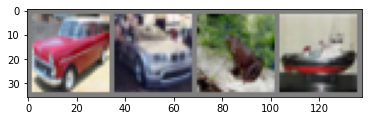

  car   car  frog  ship


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)


cpu


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [97]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.178
[1,  4000] loss: 1.852
[1,  6000] loss: 1.692
[1,  8000] loss: 1.597
[1, 10000] loss: 1.524
[1, 12000] loss: 1.467
[2,  2000] loss: 1.412
[2,  4000] loss: 1.369
[2,  6000] loss: 1.346
[2,  8000] loss: 1.336
[2, 10000] loss: 1.306
[2, 12000] loss: 1.281
Finished Training


In [98]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

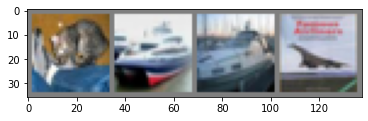

GroundTruth:    cat  ship  ship plane


In [105]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [106]:

net = Net()
net.to(device)

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [107]:
outputs = net(images.to(device))


In [108]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [113]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [115]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 65 %
Accuracy of  bird : 36 %
Accuracy of   cat : 29 %
Accuracy of  deer : 40 %
Accuracy of   dog : 36 %
Accuracy of  frog : 87 %
Accuracy of horse : 38 %
Accuracy of  ship : 72 %
Accuracy of truck : 61 %


## Training on GPU

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [73]:
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [74]:
inputs, labels = data[0].to(device), data[1].to(device)
